In [310]:
%matplotlib  inline

### Speckle Noise Reduction Method Based on Fuzzy Approach for Synthetic Aperture Radar Images 

https://pdfs.semanticscholar.org/8439/730f3520c7a9614e46716c0b76ee205abca1.pdf

## Preparation

In [311]:
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy import misc, signal

import imageio

import pywt

import skfuzzy as fuzz
from skfuzzy import control as ctrl

Text(0.5, 1.0, 'Blurred pict')

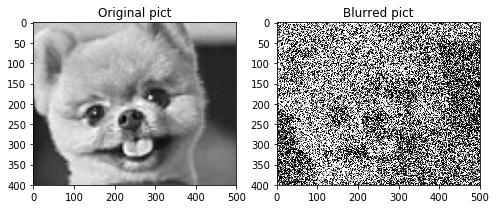

In [312]:
pict = imageio.imread('lab - 8/test.jpg')
pict = pict[400:800, 1300:1800, 0]
blurred_1 = pict + np.random.normal(loc=0, scale=200, size=pict.shape)
blurred_1 = np.clip(blurred_1, 0, 255, out=blurred_1)

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(pict, cmap='gray')
ax[0].set_title('Original pict')
ax[1].imshow(blurred_1, cmap='gray')
ax[1].set_title('Blurred pict')

Text(0.5, 1.0, 'Blurred pict')

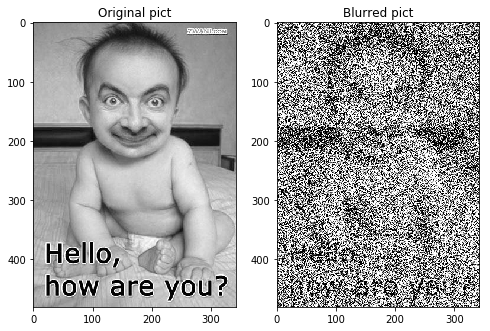

In [313]:
pict = imageio.imread('lab - 8/test1.jpg')
pict = pict[:, :, 0]
blurred_2 = pict + np.random.normal(loc=0, scale=200, size=pict.shape)
blurred_2 = np.clip(blurred_2, 0, 255, out=blurred_2)

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(pict, cmap='gray')
ax[0].set_title('Original pict')
ax[1].imshow(blurred_2, cmap='gray')
ax[1].set_title('Blurred pict')

## Fuzzy filters (ATMAV, ATMED)
* ATMED - Asymmetrical Triangular Median Filter.
* ATMAV - Asymmetrical Triangular Moving Average Filter

In [314]:
def ATMED(value, v_min, v_median, v_max):
    
    if v_min <= value <= v_median:
        return 1 - (v_median - value) / (v_median - v_min)
    
    if v_median <= value <= v_max:
        return 1 - (value - v_median) / (v_max - v_median)
    
    if v_min == v_median or v_median == v_max:
        return 1

In [315]:
def ATMAV(value, v_min, v_mean, v_max):
    
    if v_min <= value <= v_mean:
        return 1 - (v_mean - value) / (v_mean - v_min)
    
    if v_mean <= value <= v_max:
        return 1 - (value - v_mean) / (v_max - v_mean)
    
    if v_min == v_mean or v_mean == v_max:
        return 1

In [316]:
def construct_filter(sub_matrix, filter_name='ATMAV'):
    
    row = sub_matrix.ravel().astype(np.float64)
    
    v_min = np.min(row)
    v_max = np.max(row)
    
    v_median = np.median(row)
    v_mean = np.mean(row)

    func = None
    
    if filter_name == 'ATMAV':
        v_m = v_mean
        func = ATMAV
    if filter_name == 'ATMED':
        v_m = v_median
        func = ATMED
        
    FILTER = np.zeros(sub_matrix.shape)
    
    h, w = FILTER.shape
    
    for i in range(h):
        for j in range(w):
            value = sub_matrix[i, j]
            FILTER[i, j] = func(value, v_min, v_m, v_max)
            
    return FILTER

In [317]:
def fuzzy_filter(img, window_size=12, method='ATMAV'):

    h, w = img.shape
    
    output = np.zeros(img.shape)
    
    output[0, :] = img[0, :]
    output[:, 0] = img[:, 0]
    output[-1, :] = img[-1, :]
    output[:, -1] = img[:, -1]
    
    for i in range(window_size, h - window_size - 1):
        for j in range(window_size, w - window_size - 1):
            sub_img = img[i - window_size: i + window_size + 1, j - window_size: j + window_size + 1]
            FILTER = construct_filter(sub_matrix=sub_img, filter_name=method)
            
            output[i, j] = (sub_img * FILTER).ravel().sum()
            
    return output

# Comparison of there filters

# Results

In [318]:
def util(blurred):
    coeffs = pywt.dwt2(blurred, 'haar')
    cA, (cH, cV, cD) = coeffs
    cA = fuzzy_filter(cA, method='ATMAV', window_size=1)
    cH = np.clip(cH, -10, 10)
    cV = np.clip(cV, -10, 10)
    cD = np.clip(cD, -10, 10)
    r = np.zeros(cD.shape)
    atmav_recovered = pywt.idwt2((cA, (cH, cV, cD)), 'haar')
    
    coeffs = pywt.dwt2(blurred, 'haar')
    cA, (cH, cV, cD) = coeffs
    cA = fuzzy_filter(cA, method='ATMED', window_size=1)
    cH = np.clip(cH, -10, 10)
    cV = np.clip(cV, -10, 10)
    cD = np.clip(cD, -10, 10)
    r = np.zeros(cD.shape)
    atmed_recovered = pywt.idwt2((cA, (cH, cV, cD)), 'haar')
    
    wiener_recovered = scipy.signal.wiener(np.array(blurred))
    
    return atmed_recovered, atmav_recovered, wiener_recovered

In [319]:
def plot_results(blurred, atmav_recovered, atmed_recovered, wiener_recovered):
    plt.figure(figsize=(10, 8))

    plt.subplot(221)
    plt.title('Изначально зашумленное изображение')
    plt.imshow(blurred, cmap='gray')

    plt.subplot(222)
    plt.title('Fuzzy ATMAV')
    plt.imshow(atmav_recovered, cmap='gray')

    plt.subplot(223)
    plt.title('Fuzzy ATMED')
    plt.imshow(atmed_recovered, cmap='gray')

    plt.subplot(224)
    plt.title('Wiener filter')
    plt.imshow(wiener_recovered, cmap='gray')

    plt.show()

## 1-st comparison

/home/hegnatin/projects/.venv/lib/python3.6/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
/home/hegnatin/projects/.venv/lib/python3.6/site-packages/scipy/signal/signaltools.py:940: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/home/hegnatin/projects/.venv/lib/python3.6/site-packages/scipy/signal/signaltools.py:940: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


CPU times: user 12.5 s, sys: 13 ms, total: 12.5 s
Wall time: 12.5 s


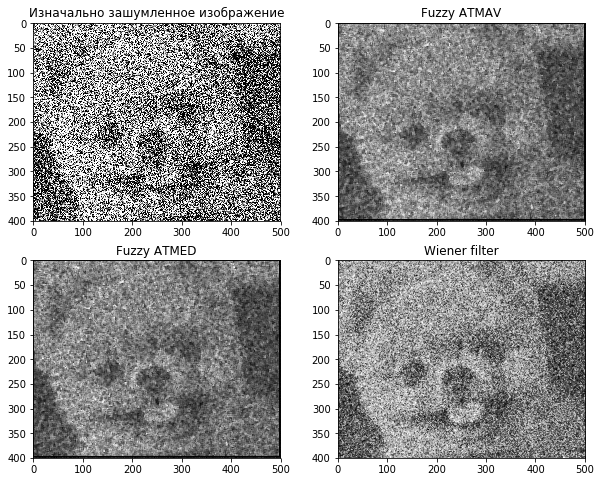

In [320]:
%time atmed_recovered, atmav_recovered, wiener_recovered = util(blurred_1)
plot_results(blurred_1, atmed_recovered, atmav_recovered, wiener_recovered)

## 2-nd comparison

CPU times: user 10.3 s, sys: 0 ns, total: 10.3 s
Wall time: 10.3 s


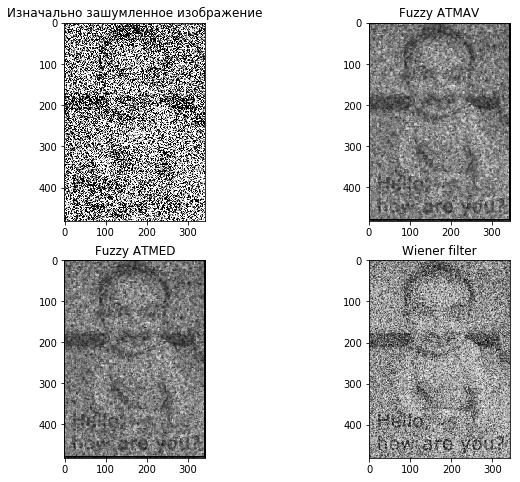

In [321]:
%time atmed_recovered, atmav_recovered, wiener_recovered = util(blurred_2)
plot_results(blurred_2, atmed_recovered, atmav_recovered, wiener_recovered)

# Image contrast enhancment by fuzzy inference system

From "Image Enhancement Using MamdaniFuzzy Inference System":[fuzzy_logic/Labs and lectures/Image Enhancement Using MamdaniFuzzy Inference System.pdf]

In [322]:
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy import misc, signal

import imageio

import pywt

import skfuzzy as fuzz
from skfuzzy import control as ctrl

import tqdm

from skimage import io

In [323]:
pict = io.imread('lab - 8/test1.jpg', as_gray=True)
# pict = pict / 255
N_MIN, N_MAX, M_MIN, M_MAX = 110, 210, 120, 220
pict_part = pict[N_MIN:N_MAX, M_MIN:M_MAX]

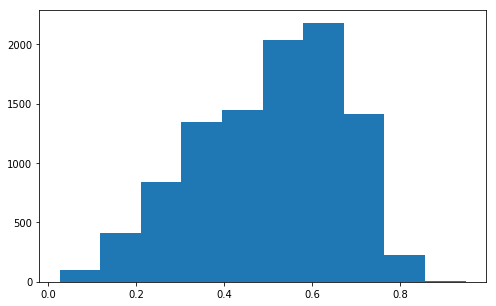

In [324]:
plt.figure(figsize=(8, 5))
plt.hist(pict_part.flatten())
plt.show()

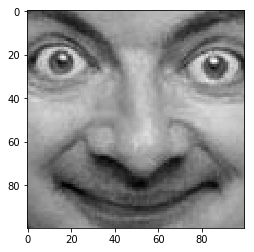

In [325]:
plt.imshow(pict_part, cmap='gray')

In [326]:
def stat_apply_to_image(data, window=2, stat_func=None):
    rows, cols = data.shape
    P_STAT = np.copy(data)
    
    dv = window
    
    for i in tqdm.tqdm(range(dv, rows - dv - 1), desc='[fuzzy_contrast_enhancer] iteration number: ', total=rows - 2 * dv - 1):
        for j in range(dv, cols - dv - 1):
            moveable_window = data[i - dv: i + dv + 1, j - dv: j + dv + 1]

            P_STAT[i, j] = stat_func(moveable_window.flatten())
            
    return P_STAT

## Mandami/Sugeno FIS

In [327]:
def generate_FIS(min_input_value=0, mean_input_value=0.5, high_input_value=1, 
                 min_output_value=0, mean_output_value=0.5, high_output_value=1):
    
    pixel_input = ctrl.Antecedent(np.arange(min_input_value, high_input_value, 0.1), 'pixel_input')
    pixel_output = ctrl.Consequent(np.arange(min_output_value, high_output_value, 0.1), 'pixel_output')

    pixel_input['min'] = fuzz.trimf(pixel_input.universe, [0, min_input_value, mean_input_value])
    pixel_input['mean'] = fuzz.trimf(pixel_input.universe, [min_input_value, mean_input_value, high_input_value])
    pixel_input['great'] = fuzz.trimf(pixel_input.universe, [mean_input_value, high_input_value, 1])

    pixel_output['less'] = fuzz.trimf(pixel_output.universe, [0.0, min_output_value, mean_output_value])
    pixel_output['mean'] = fuzz.trimf(pixel_output.universe, [min_output_value, mean_output_value, high_output_value])
    pixel_output['greater'] = fuzz.trimf(pixel_output.universe, [mean_output_value, high_output_value, 1])

    rule_mandami_1 = ctrl.Rule(pixel_input['min'], pixel_output['less'])
    rule_mandami_2 = ctrl.Rule(pixel_input['mean'], pixel_output['mean'])
    rule_mandami_3 = ctrl.Rule(pixel_input['great'], pixel_output['greater'])

    pixels_mandami_ctrl = ctrl.ControlSystem([rule_mandami_1, rule_mandami_2, rule_mandami_3])

    pixels_mandami = ctrl.ControlSystemSimulation(pixels_mandami_ctrl)
    
    return pixels_mandami

In [328]:
def fis_apply_to_image(data, P, FIS=None):
    rows, cols = P.shape
    
    for i in tqdm.tqdm(range(rows), total=rows, desc='[convert_data_to_fis] iteration number'):
        for j in range(cols):
            if P[i, j] > 0:
                FIS.input['pixel_input'] = P[i, j]
                FIS.compute()
                P[i, j] = FIS.output['pixel_output']  
                
    return P

In [329]:
def enhancer(data, window=3, stat_func=None, FIS=None):
    
    channel = np.copy(data)
    stat_channel = stat_apply_to_image(channel, window=window, stat_func=stat_func)
    stat_channel_after_fis = fis_apply_to_image(channel, stat_channel, FIS)
    
    return stat_channel_after_fis

[fuzzy_contrast_enhancer] iteration number: 100%|██████████| 97/97 [00:00<00:00, 223.81it/s]


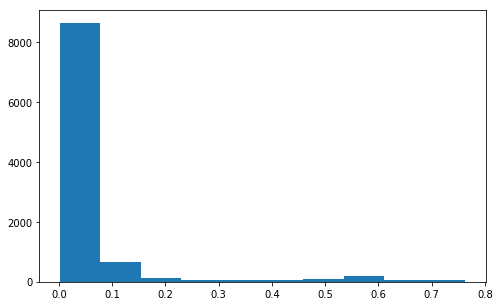

In [330]:
stat_image = stat_apply_to_image(pict_part, window=1, stat_func=np.std)
plt.figure(figsize=(8, 5))
plt.hist(stat_image.flatten())
plt.show()

[convert_data_to_fis] iteration number: 100%|██████████| 100/100 [00:03<00:00, 28.88it/s]


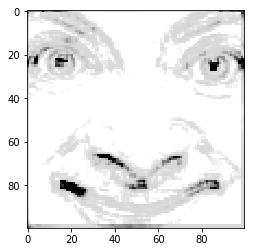

In [331]:
FIS = generate_FIS(min_input_value=0.2, mean_input_value=0.5, high_input_value=0.9, min_output_value=0.1, high_output_value=0.9)

stat_func = lambda x: np.min(x) / np.max(x) if (np.max(x) - np.min(x)) != 0 else 1

res = enhancer(pict_part, window=1, stat_func=stat_func, FIS=FIS)
plt.imshow(res, cmap='gray')

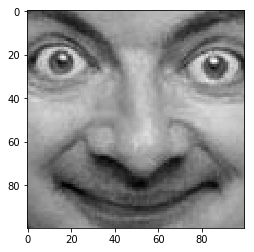

In [332]:
plt.imshow(pict_part, cmap='gray')